In [262]:
#get dataframe of tweet_id and user_id
import pandas as pd
import csv
from twython import Twython
import time
from collections import defaultdict

df = pandas.read_csv('gamergate_tweets.csv')
user_ids = df['user_id'].tolist()[:5000]

# Consumer & Auth keys and tokens for authentication
CONSUMER_KEY = "48r56upQvsnTiSDfY4CNwIpCQ"
CONSUMER_SECRET = "VqZhFW7GqogdKXJnpuS0umVe211bFgoCdaQlRdRMayvrbdDh3k"
OAUTH_TOKEN = "18000528-Scl8a1pLinqP4KWtaa3f8EN0M1vqAGTyYXMtsLIGm"
OAUTH_TOKEN_SECRET = "NcIvLeqVbwwBegabvo7946FVIaDN0CAaJ7aS2aV7pZFzC"

twitter = Twython(CONSUMER_KEY, CONSUMER_SECRET, OAUTH_TOKEN, OAUTH_TOKEN_SECRET)

# check rate limit
# twitter.get_application_rate_limit_status()['resources']['followers']

In [530]:
# Get followers/id 2
def test(twitter, user_id):
    follower_ids = []
    # Fetch the followings as a cursored collection (up to 5000 per call).
    cursor = -1
    #follower_ids = twitter.get_followers_ids(user_id=user_id, cursor=cursor)
    remaining = twitter.get_application_rate_limit_status()['resources']['followers']['/followers/ids']['remaining']
    while cursor != 0:
        if remaining < 2:
            print "start waiting ", cursor
            time.sleep(920)
            print "done waiting"
            twitter = Twython(CONSUMER_KEY, CONSUMER_SECRET, OAUTH_TOKEN, OAUTH_TOKEN_SECRET)
            remaining = twitter.get_application_rate_limit_status()['resources']['followers']['/followers/ids']['remaining']
            print remaining
        else:
            twitter = Twython(CONSUMER_KEY, CONSUMER_SECRET, OAUTH_TOKEN, OAUTH_TOKEN_SECRET)
            resp = twitter.get_followers_ids(user_id=user_id, cursor=cursor)
            follower_ids += resp['ids']
            cursor = resp['next_cursor']
            remaining = twitter.get_application_rate_limit_status()['resources']['followers']['/followers/ids']['remaining']
            print remaining
    return follower_ids

# GET followers/list
def get_follower_list(twitter, user_id):
    followers = []
    print twitter.get_application_rate_limit_status()['resources']['followers']['/followers/list']['remaining']
    cursored = twitter.cursor(twitter.get_followers_list, id=user_id)
    print twitter.get_application_rate_limit_status()['resources']['followers']['/followers/list']['remaining']
    for follower in cursored:
        followers.append(follower)
    return followers

# GET users/lookup
def get_user_lookup(twitter, current):
    user_obj = twitter.lookup_user(user_id=current)
    return user_obj
    
# GET followers/ids
def get_follower_ids(twitter, user_id):
    followers = []
    cursored = twitter.cursor(twitter.get_followers_ids, id=user_id)
    for follower in cursored:
        followers.append(follower)
    return followers

In [4]:
user_list = []
start = 0
end = 100
while end <= 5000:
    current = user_ids[start:end]
    start += 100
    end += 100
    users = get_user_lookup(twitter, current)
    for i in range(0, len(users)):
        each_user = []
        each_user.append(user_ids[i]) # user[0] = user_id
        each_user.append(users[i]['followers_count']) # user[1] = follower count
        each_user.append(users[i]['favourites_count'])
        each_user.append(users[i]['location'])
        user_list.append(each_user)

In [472]:
users_df = pandas.DataFrame(user_list, columns=["User ID", "Follower Count", "Favourites Count", "Location"])
tweets_df = pandas.read_csv("all_tweets.csv")

print tweets_df.info()
print tweets_df.shape

<class 'pandas.core.frame.DataFrame'>
Int64Index: 206330 entries, 0 to 206329
Data columns (total 9 columns):
User ID        206330 non-null int64
Retweets       206330 non-null int64
Favorites      206330 non-null int64
Has_url        206330 non-null int64
Mentions       206330 non-null object
Text           206293 non-null object
Polarity       206330 non-null float64
Popularity     206330 non-null int64
numMentions    206330 non-null int64
dtypes: float64(1), int64(6), object(2)
memory usage: 15.7+ MB
None
(206330, 9)


In [469]:
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics

from sklearn.cluster import KMeans, MiniBatchKMeans
import seaborn as sns
from scipy import cluster
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
%pylab inline
%matplotlib inline

def evaluate_clusters(X, max_clusters):
    error = np.zeros(max_clusters+1)
    error[0] = 0;
    for k in range(1,max_clusters+1):
        kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10)
        kmeans.fit_predict(X)
        error[k] = kmeans.inertia_
    plt.plot(range(1,len(error)),error[1:])
    plt.xlabel('Number of clusters')
    plt.ylabel('Error')

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [517]:
text_list = tweets_df.dropna().Text.values
vectorizer = TfidfVectorizer(max_df=.9, max_features=25,
                             min_df=3, stop_words='english',
                             use_idf=True)

stop_words = list(vectorizer.get_stop_words())
stop_words.append('like')
stop_words.append('just')
stop_words.append('tweets')
stop_words.append('twitter')
stop_words.append("gamers")
stop_words.append("gamer")
stop_words.append("games")
stop_words.append("game")
stop_words.append("gaming")
stop_words.append("month")
stop_words.append("hours")
stop_words.append("20")
stop_words.append("want")
stop_words.append("don")
stop_words.append("did")
stop_words.append("ve")
stop_words.append("really")
stop_words.append("day")
stop_words.append("let")
stop_words.append("read")
stop_words.append("know")
stop_words.append("new")
stop_words.append("game")
stop_words.append("look")
stop_words.append("time")
stop_words.append("make")
stop_words.append("good")
stop_words.append("thing")
stop_words.append("going")
stop_words.append("does")
stop_words.append("doesn")
stop_words.append("doing")
stop_words.append("oh")
stop_words.append("hey")
stop_words.append("got")

vect = TfidfVectorizer(max_df=.9, max_features=40,
                             min_df=3, stop_words=stop_words, 
                             use_idf=True, analyzer='word')

X_ = vect.fit_transform(text_list)
X_prime = vectorizer.fit_transform(text_list)
print("n_samples: %d, n_features: %d" % X.shape)
print vect.get_feature_names()

n_samples: 206293, n_features: 8
[u'adobe', u'anti', u'bad', u'bullying', u'chriswarcraft', u'chsommers', u'clickhole', u'ethics', u'feliciaday', u'femfreq', u'gawker', u'gg', u'group', u'harassment', u'hate', u'intel', u'journalism', u'media', u'men', u'movement', u'need', u'nero', u'people', u'piece', u'playdangerously', u'remember', u'right', u'sargon_of_akkad', u'say', u'shit', u'stop', u'support', u'theralphretort', u'think', u'threats', u'trying', u'video', u'white', u'woman', u'women']


Explained variance of the SVD step: 33%


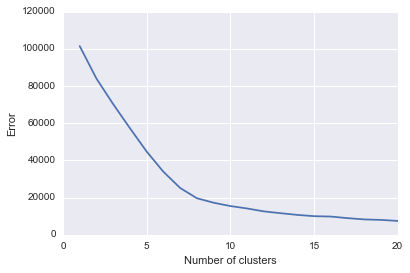

In [522]:
'''
for i in range(3, 15):
    print "================"
    print "n-components =", i
    svd = TruncatedSVD(i)
    normalizer = Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)
    X = lsa.fit_transform(X_)
    explained_variance = svd.explained_variance_ratio_.sum()
    print("Explained variance of the SVD step: {}%".format(int(explained_variance * 100)))
'''
svd = TruncatedSVD(7)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)
X = lsa.fit_transform(X_)
explained_variance = svd.explained_variance_ratio_.sum()
print("Explained variance of the SVD step: {}%".format(int(explained_variance * 100)))

evaluate_clusters(X,20)

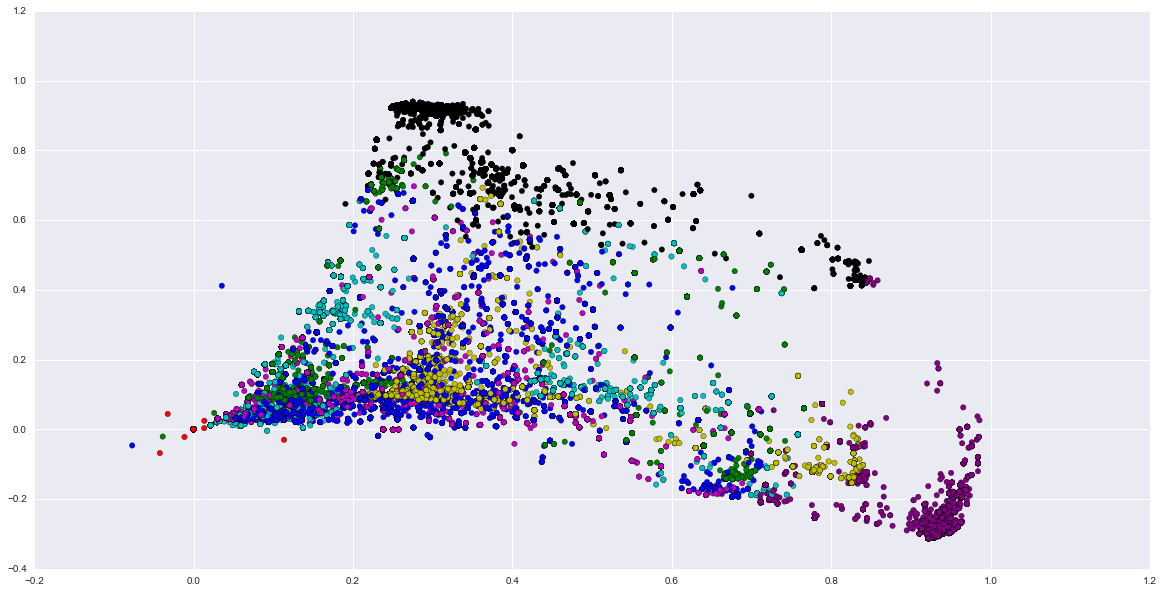

In [523]:
#kmeans = KMeans(n_clusters=12, init='k-means++', max_iter=100, n_init=1, verbose=True)
#y_pred = kmeans.fit(X)
kmeans = MiniBatchKMeans(n_clusters=8, init='k-means++', n_init=1,
                     init_size=1000, batch_size=1000, verbose=False)

#kmeans = KMeans(init='k-means++', n_clusters=7, n_init=20)
y_pred = kmeans.fit_predict(X)
centroids = kmeans.cluster_centers_
labels = kmeans.labels_
error = kmeans.inertia_
colors = np.array([x for x in ('b', 'g', 'r', 'c', 'm', 'y', 'k', 'purple', 'lime', 
                               'maroon', 'olive', 'pink', 'orange', 'silver', 'brown')])
colors = np.hstack([colors] * 20)

plt.figure(figsize=(20, 10))
plt.scatter(X[:, 0], X[:, 1], s=30, c=colors[y_pred].tolist())
#print "labels:" , labels
#print "error:", error
#print "centroids:", centroids

In [524]:
tags = np.unique(labels)
tweets_df = tweets_df.dropna()
tweets_df['Labels'] = pd.Series(labels, index=tweets_df.index)
grouped = tweets_df.groupby('Labels')
print grouped.size()
raw_clusters = []
pop_users = []
clusters = []
for t in tags:
    g = pd.DataFrame(grouped.get_group(t))
    raw_clusters.append(g)
    #pop_users.append(pd.DataFrame(grouped.get_group(t)).sort_values("Popularity", ascending=False)[:5])

for c in raw_clusters:
    byUsers = pd.DataFrame(c.groupby('User ID').sum().sort_values('Popularity', ascending=False))
    clusters.append(byUsers)
    pop_users.append(byUsers[:3])

Labels
0    26479
1    10606
2    84968
3    16460
4    19709
5    15563
6    18275
7    14233
dtype: int64


In [525]:
top_users = []
for p in pop_users:
    print p.index.values[:3]
    top_users.append(p.index.values[0])
    top_users.append(p.index.values[1])
    top_users.append(p.index.values[2])
    
top_users = np.unique(top_users)
print top_users

[14172204 28959261  7578742]
[2421921523  524901955   31640341]
[2421921523 1038152798 2791121294]
[2377815434 2747504632 2795340192]
[ 175378976 1874836183 1265807251]
[2421921523 2376881202 2791121294]
[2421921523 2791121294 2845238149]
[2747504632 1052040667 2421921523]
[   7578742   14172204   28959261   31640341  175378976  524901955
 1038152798 1052040667 1265807251 1874836183 2376881202 2377815434
 2421921523 2747504632 2791121294 2795340192 2845238149]


In [521]:
# IMPORTANT @Spacekatgal is one of the victim. in cluster 1 the three most popular users tweets about her
# that cluster might be a lot of people that's talking about her
top_groups = nonan_tweets_df[nonan_tweets_df['User ID'].isin(top_users.tolist())].groupby('User ID')
print top_groups.get_group(14172204)

         User ID  Retweets  Favorites  Has_url     Mentions  \
49605   14172204         1          0        1   [32793160]   
49651   14172204         1          0        0   [32793160]   
152051  14172204       175          0        0   [14904191]   
152133  14172204      1164          0        0  [158558510]   
193717  14172204      7709          0        0   [17264476]   

                                                     Text  Polarity  \
49605    @dekkerdreyer: I've been wrong about . It's n...     0.000   
49651    @dekkerdreyer:  I don't believe it's not abou...     0.116   
152051   @Ryon_D: Somewhere, a -er asks his female han...     0.000   
152133   @TaraLongest: Just to reiterate, a member of ...     0.062   
193717   @Spacekatgal: The police just came by. Husban...     0.255   

        Popularity  numMentions  Labels  
49605            1            1       1  
49651            1            1      10  
152051         175            1       1  
152133        1164        

In [526]:
twitter = Twython(CONSUMER_KEY, CONSUMER_SECRET, OAUTH_TOKEN, OAUTH_TOKEN_SECRET)
top_obj = get_user_lookup(twitter, top_users.tolist())
for o in top_obj:
    print o['id'], o['followers_count']

7578742 190
14172204 204
28959261 77
31640341 304
175378976 189684
524901955 2974
1038152798 118
1052040667 1344
1265807251 68
1874836183 1115
2376881202 580
2377815434 216000
2421921523 1850
2747504632 1605
2791121294 3021
2795340192 537
2845238149 1074


In [531]:
follower_ids = defaultdict(list)
twitter = Twython(CONSUMER_KEY, CONSUMER_SECRET, OAUTH_TOKEN, OAUTH_TOKEN_SECRET)
remaining = twitter.get_application_rate_limit_status()['resources']['followers']['/followers/ids']['remaining']
for u in top_users.tolist():
    print remaining
    if remaining < 2:
        print "start waiting ", u
        time.sleep(920)
        print "done waiting"
        
    twitter = Twython(CONSUMER_KEY, CONSUMER_SECRET, OAUTH_TOKEN, OAUTH_TOKEN_SECRET)
    print u
    follower_ids[u] = test(twitter, u)
    twitter = Twython(CONSUMER_KEY, CONSUMER_SECRET, OAUTH_TOKEN, OAUTH_TOKEN_SECRET)
    remaining = twitter.get_application_rate_limit_status()['resources']['followers']['/followers/ids']['remaining']
    print follower_ids.keys()


15
14172204
14
[14172204]
14
28959261
13
[14172204, 28959261]
13
31640341
12
[14172204, 28959261, 31640341]
12
175378976
11
10
9
8
7
6
5
4
3
2
1
start waiting  1456412996976517315
done waiting
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
start waiting  1415285640079357437
done waiting
15
14
13
12
11
10
9
8
7
6
5
4
3
2
[175378976, 14172204, 28959261, 31640341]
2
524901955
1
[175378976, 524901955, 14172204, 28959261, 31640341]
1
start waiting  1038152798
done waiting
1038152798
14
[175378976, 524901955, 14172204, 31640341, 28959261, 1038152798]
14
1052040667
13
[175378976, 524901955, 14172204, 31640341, 1052040667, 28959261, 1038152798]
13
1265807251
12
[175378976, 524901955, 14172204, 1265807251, 31640341, 1052040667, 28959261, 1038152798]
12
1874836183
11
[175378976, 524901955, 14172204, 1265807251, 31640341, 1874836183, 1052040667, 28959261, 1038152798]
11
2376881202
10
[175378976, 524901955, 14172204, 2376881202, 1265807251, 31640341, 1874836183, 1052040667, 28959261, 1038152798]
10
237781543

In [559]:
print follower_ids[7578742]

14
[1870144128, 4839444327, 4827614230, 20452100, 711496146242445312, 2735348801, 4044924562, 4827008919, 4038530543, 20963241, 2951946238, 1301709182, 35113926, 4786707913, 32335485, 4617953655, 4186525707, 2602619424, 17972212, 4381725388, 198561083, 3447645196, 18548136, 222202761, 2384029862, 3437776454, 3240531560, 113746177, 235253769, 1942592666, 2279556006, 2963830033, 608864064, 109354637, 2391874478, 3052830066, 25465969, 1870228820, 34127944, 1156152529, 54281549, 2918117617, 1726076226, 2319157155, 221616985, 133584360, 55753, 2847323395, 2798630002, 2778872259, 183532026, 389725587, 2755523316, 2785096057, 19123879, 2297358990, 121913943, 68233124, 2291188094, 2308984784, 2169627935, 1158729439, 15518281, 518968361, 395127008, 2259682914, 138007573, 1476013080, 244923201, 16008617, 29306765, 16875756, 1301426474, 337338496, 115179501, 416205815, 111266356, 88241201, 40272260, 156870568, 261436914, 29654066, 1150279562, 1146099584, 45228278, 90938377, 912286548, 900005089, 

In [560]:
len(follower_ids.keys())
for k in follower_ids.keys():
    print k, len(follower_ids[k])

175378976 189677
2795340192 537
524901955 2974
2845238149 1074
2377815434 216040
14172204 204
2791121294 3019
2376881202 581
1265807251 68
31640341 304
7578742 191
1874836183 1116
2747504632 1606
2421921523 1850
1052040667 1345
28959261 77
1038152798 118


In [561]:
for p in pop_users:
    _curr = []
    for u in p.index.values:
        print u, len(follower_ids[u])
        _curr.append(follower_ids[u])
    #print len(_curr)
    p['follower_ids'] = np.array(_curr)
    print p.info()

14172204 204
28959261 77
7578742 191
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3 entries, 14172204 to 7578742
Data columns (total 10 columns):
Retweets                3 non-null int64
Favorites               3 non-null int64
Has_url                 3 non-null int64
Polarity                3 non-null float64
Popularity              3 non-null int64
numMentions             3 non-null int64
Labels                  3 non-null int32
follower_ids            3 non-null object
Followers In Cluster    3 non-null object
Followers In df         3 non-null object
dtypes: float64(1), int32(1), int64(5), object(3)
memory usage: 252.0+ bytes
None
2421921523 1850
524901955 2974
31640341 304
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3 entries, 2421921523 to 31640341
Data columns (total 10 columns):
Retweets                3 non-null int64
Favorites               3 non-null int64
Has_url                 3 non-null int64
Polarity                3 non-null float64
Popularity              3

/Users/Minying/envs/cs591-datamining/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [562]:
print pop_users[0].follower_ids
print len(pop_users)

User ID
14172204    [722290850466672641, 75122893, 27156169, 49228...
28959261    [33014441, 93656804, 3489371850, 3300100618, 1...
7578742     [1870144128, 4839444327, 4827614230, 20452100,...
Name: follower_ids, dtype: object
8


In [563]:
nonan_tweets_df.to_csv("clustered_tweets2.csv", sep="\t", encoding='utf-8')

In [564]:
all_pop_users = pd.concat([x for x in pop_users], ignore_index=False)
#print all_pop_users.info()
print len(clusters)

8


In [573]:
all_users = set(nonan_tweets_df['User ID'].tolist())
print len(all_users)
for i in range(len(pop_users)):
    F_IN_C = []
    F_IN_DF = []
    Ratio = []
    follower_count = []
    followers = pop_users[i]['follower_ids'].tolist()
    cluster_users = set(clusters[i].index.tolist())
    for fol in followers:
        print len(fol)
        f_in_df = []
        f_in_cluster = []
        for f in fol:
            if f in cluster_users:
                f_in_cluster.append(f)

            if f in all_users:
                f_in_df.append(f)
        
        try:
            r = len(f_in_cluster) * 1.0 / len(f_in_df)
        except Exception:
            r = 0.0
        print r
        F_IN_C.append(f_in_cluster)
        F_IN_DF.append(f_in_df)
        Ratio.append(r)
        follower_count.append(len(fol))
    
    pop_users[i]['follower_count'] = follower_count
    pop_users[i]['Followers In Cluster'] = F_IN_C
    pop_users[i]['Followers In df'] = F_IN_DF
    pop_users[i]['Ratio'] = Ratio
    
print pop_users[0].info()
print pop_users[-1].info()

/Users/Minying/envs/cs591-datamining/lib/python2.7/site-packages/ipykernel/__main__.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Minying/envs/cs591-datamining/lib/python2.7/site-packages/ipykernel/__main__.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Minying/envs/cs591-datamining/lib/python2.7/site-packages/ipykernel/__main__.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

32501
204
1.0
77
0.0
191
0.0
1850
0.658823529412
2974
0.425287356322
304
0.705882352941
1850
0.912418300654
118
0.961038961039
3019
0.900485436893
216040
0.429569266589
1606
0.682137834037
537
0.692
189677
0.627880447182
1116
0.45
68
0.590909090909
1850
0.718954248366
581
0.739926739927
3019
0.705097087379
1850
0.725490196078
3019
0.745145631068
1074
0.717894736842
1606
0.679324894515
1345
0.699596774194
1850
0.675816993464
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3 entries, 14172204 to 7578742
Data columns (total 12 columns):
Retweets                3 non-null int64
Favorites               3 non-null int64
Has_url                 3 non-null int64
Polarity                3 non-null float64
Popularity              3 non-null int64
numMentions             3 non-null int64
Labels                  3 non-null int32
follower_ids            3 non-null object
Followers In Cluster    3 non-null object
Followers In df         3 non-null object
follower_count          3 non-null int64
Ra

In [574]:
all_pop_users.to_csv("all_pop_users2.csv", sep="\t", encoding='utf-8')

In [576]:
for p in pop_users:
    print p.follower_count
        

User ID
14172204    204
28959261     77
7578742     191
Name: follower_count, dtype: int64
User ID
2421921523    1850
524901955     2974
31640341       304
Name: follower_count, dtype: int64
User ID
2421921523    1850
1038152798     118
2791121294    3019
Name: follower_count, dtype: int64
User ID
2377815434    216040
2747504632      1606
2795340192       537
Name: follower_count, dtype: int64
User ID
175378976     189677
1874836183      1116
1265807251        68
Name: follower_count, dtype: int64
User ID
2421921523    1850
2376881202     581
2791121294    3019
Name: follower_count, dtype: int64
User ID
2421921523    1850
2791121294    3019
2845238149    1074
Name: follower_count, dtype: int64
User ID
2747504632    1606
1052040667    1345
2421921523    1850
Name: follower_count, dtype: int64


In [392]:
print nonan_tweets_df.loc[nonan_tweets_df['User ID'].isin(all_pop_users.index.tolist())].groupby('User ID').sum()

              Retweets  Favorites  Has_url  Polarity  Popularity  numMentions  \
User ID                                                                         
14172204.0        7711          0        1    0.3710        7711            3   
96459347.0        3468          0        2    0.4190        3468            8   
246557633.0       7709          0        0    0.8980        7709            1   
356199261.0      12514          7       38   54.1130       12521          352   
738809107.0       3299          0        0    0.0000        3299            3   
1198804064.0      3299          0        0    0.6130        3299            3   
2421921523.0     21027         13      101   87.1797       21040          551   
2747504632.0     10681          0       18   37.6636       10681          190   
2826800366.0     17486          5       39   55.5863       17491          280   
1038152798       19637          2       95   97.6197       19639          538   
1265807251       12132      

In [479]:
print tweets_df.groupby('User ID').size().sort_values(ascending=False)[:50]
#print id_group.size().sort_values(ascending=False)

User ID
2791121294    1918
2807060009    1171
2421921523     901
1132062200     730
1038152798     714
183993932      709
2845238149     704
2814040284     663
112614146      639
29431077       637
500240347      565
2806977060     564
465606946      555
2837175356     545
2702828160     541
1335585896     534
139292752      511
2563030626     482
2784707673     477
2793807454     470
274109576      470
2801270976     458
2662173163     455
16710197       451
356199261      451
18746944       450
2800681614     448
2757067388     445
289490370      444
2585165988     440
115601411      434
2822712590     432
1052040667     429
2792513884     423
544001732      414
2815279566     409
2807602670     403
588226577      400
2814885768     390
2792749508     374
2506962415     372
2311435027     371
2814008060     370
1012398272     363
311405077      362
37093993       348
830859110      339
175428809      336
2747114010     335
854203626      321
dtype: int64


In [423]:
print id_group.get_group('2791121294')[['Retweets', "Text"]].sort_values('Retweets', ascending=False)#.groupby('Text').size().sort_values(ascending=False)

        Retweets                                               Text
356106       434   @TheRalphRetort: Doing business with @gawker,...
332033       430   @CHSommers: New Pew study on online harassmen...
349158       427   @CHSommers: A defense of  coming Monday from ...
366978       381   @Toshi_TNE: 40th in my series of people of . ...
331973       372   @MomsAgainstGam: Our interns asked actor @Ada...
341043       308   @HiddenTranny: Plz Re-tweet:  is Anti-Harassm...
331778       299   @TheIvyClover1:  \n \n\n \n \n\nSpread these ...
361494       290   @GGfeminist: I, GloriousLeader of , officiall...
332385       257   @GamingAndPandas: Note the narrative shift, ....
373994       243   @Salondotcom: Why I broke character to link s...
68237        240   @clairlemon: Critiquing the methodologies of ...
335229       230   @CathyYoung63: Well, it's been a long time co...
339753       224   @oliverbcbell: "Intel is run by craven idiots...
77515        220   @JennieBharaj: This week was 

In [424]:
print id_group.get_group(2791121294.0).sort_values('Retweets', ascending=False)[['Retweets', "Text"]]

        Retweets                                               Text
46995        538   @CHSommers: Cathy Young concludes that  is an...
399415       517   @Lemmingbot: Before @Sargon_of_Akkad distract...
26563        482   @CHSommers: Didn't the editorial director of ...
40765        366   @Nero: NEW, by me: "Incredibly,  is winning -...
29817        364   @lizzyf620: We sure are putting a whole lot o...
38329        299   @TheIvyClover1:  \n \n\n \n \n\nSpread these ...
404597       295   @Nero: NEW, by me—Gawker: ‘dishonest fascists...
30356        287   @CHSommers: Watch Jimmy Kimmel take down Gawk...
26901        249   @Nero: What  is doing happens very rarely: th...
63878        240   @femfreq:  has its roots in a series of remix...
40833        233   @GGfeminist: Just a reminder to neutrals, thi...
47402        230   @CathyYoung63: Well, it's been a long time co...
26592        225   @Nero: Remember, : bad headlines just don't m...
404434       213   @Nero: Real reason the author

In [496]:
tweets_df.sort_values('Popularity', ascending=False)[:300]

,User ID,Retweets,Favorites,Has_url,Mentions,Text,Polarity,Popularity,numMentions
74971,28959261,7709,0,0,[17264476],@Spacekatgal: The police just came by. Husban...,0.1230,7709,1
22862,246557633,7709,0,0,[17264476],@Spacekatgal: The police just came by. Husban...,0.8980,7709,1
193717,14172204,7709,0,0,[17264476],@Spacekatgal: The police just came by. Husban...,0.2550,7709,1
181746,7578742,7709,0,0,[17264476],@Spacekatgal: The police just came by. Husban...,1.0000,7709,1
93129,2377815434,2219,1738,1,[],Did we get this right?,0.0000,3957,0
434,48447512,3299,0,0,"[17264476, 2803191, 47667972]",@Spacekatgal: I call upon @Intel to take a st...,0.9050,3299,3
31705,96459347,3299,0,0,"[17264476, 2803191, 47667972]",@Spacekatgal: I call upon @Intel to take a st...,0.0000,3299,3
30566,1198804064,3299,0,0,"[17264476, 2803191, 47667972]",@Spacekatgal: I call upon @Intel to take a st...,0.6130,3299,3
20514,23519650,3299,0,0,"[17264476, 2803191, 47667972]",@Spacekatgal: I call upon @Intel to take a st...,0.8280,3299,3
67741,2251032547,3299,0,0,"[17264476, 2803191, 47667972]",@Spacekatgal: I call upon @Intel to take a st...,0.1990,3299,3
